Мохляков П.А. \
М8О-408Б-19 \
Вариант 3

## Лабораторная работа 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import tqdm

2 класса сигналов

In [2]:
def f1(k: float):
    return np.sin(4*np.pi*k)

def f2(k: float):
    return np.sin(k**2 - 15*k + 3) - np.sin(k)**2 + 0.5

Входная функция и ее класстфикация

In [3]:
h = 0.025
k1 = np.arange(0, 1+h,h)
k2 = np.arange(0.9, 3.1+h,h)
p1 = f1(k1)
p2 = f2(k2)
r = [3,5,2]
p = np.concatenate((np.tile(p1,r[0]),
                    p2,
                    np.tile(p1,r[1]),
                    p2,
                    np.tile(p1,r[2]),
                    p2))
t = np.concatenate((np.ones(len(p1)*r[0]),
                    -1*np.ones(len(p2)),
                    np.ones(len(p1)*r[1]),
                    -1*np.ones(len(p2)),
                    np.ones(len(p1)*r[2]),
                    -1*np.ones(len(p2))))
x = np.arange(len(p))*h

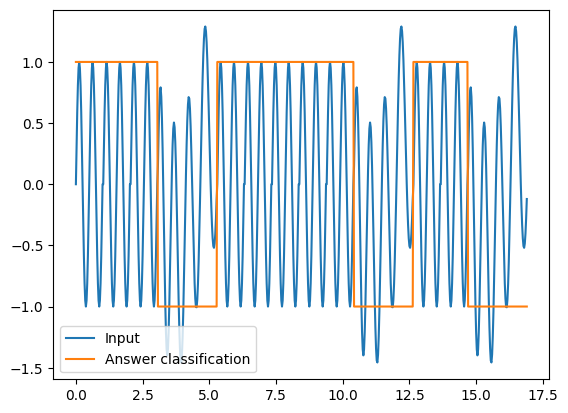

In [4]:
plt.plot(x, p, label='Input')
plt.plot(x, t, label='Answer classification')
plt.legend()

Создаем датасет

In [5]:
w = 5
X = [p[i:i+w].astype('float32') for i in range(0, len(p) - w)]
y = [t[i:i+w].astype('float32') for i in range(0, len(p) - w)]
data = [(x,y) for x, y in zip(X,y)]
train_dataloader = DataLoader(data, batch_size=1, shuffle=False)

Класс слоя Элмана

In [6]:
class ElmanLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        w1 = torch.randn(size_in, size_out)
        w2 = torch.randn(size_out, size_out)
        b = torch.randn(size_out)
        self.w1 = nn.Parameter(w1)
        self.w2 = nn.Parameter(w2)
        self.b = nn.Parameter(b)

    def forward(self, x):
        out = torch.matmul(x, self.w1)
        out = torch.add(out, self.b)
        if hasattr(self, "prev"):
            d = torch.matmul(self.prev, self.w2)
            out = torch.add(out, d)
        out = torch.tanh(out)
        self.prev = torch.tensor(out)
        return out
    
    def del_prev(self):
        if hasattr(self, "prev"):
            delattr(self, "prev")

Модель

In [14]:
vectoriz = 8
elman = ElmanLayer(w,vectoriz)
linear = nn.Linear(vectoriz, w)
model = nn.Sequential(elman,linear)

Тренеруем модель

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epoch = 300
model.train()

loses = []
for ep in tqdm.tqdm(range(epoch)):
    model[0].del_prev()
    epoch_loss = []
    for (inp, out) in train_dataloader:
        pred = model(inp)
        
        loss = loss_fn(pred, out)
        loss = torch.sqrt_(loss)
        epoch_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    loses.append(np.mean(epoch_loss))

  0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_684/370478990.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prev = torch.tensor(out)
100%|██████████| 300/300 [01:43<00:00,  2.89it/s]


График ошибки

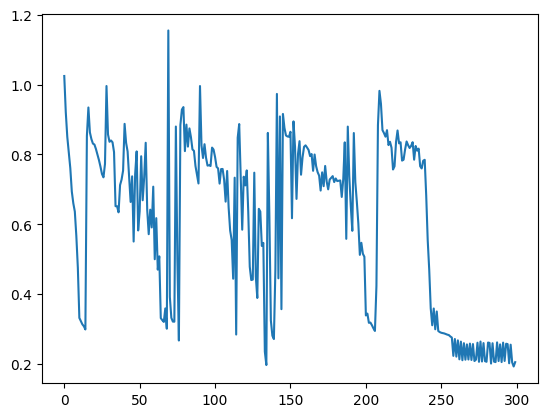

In [16]:
plt.plot(np.arange(epoch), loses)

Делаем предсказание

In [17]:
model.eval()
model[0].del_prev()
pred = []
for (inp, out) in tqdm.tqdm(train_dataloader):
    pred.append(model(inp).detach().numpy())

  0%|          | 0/672 [00:00<?, ?it/s]/tmp/ipykernel_684/370478990.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prev = torch.tensor(out)
100%|██████████| 672/672 [00:00<00:00, 8307.68it/s]


Обрабатываем предсказание

In [18]:
sum_ped = [0]*len(p)
for i, window in enumerate(pred):
    for j, item in enumerate(window[0]):
        sum_ped[i+j] = item

ans = [1 if elem > 0 else -1 for elem in sum_ped]

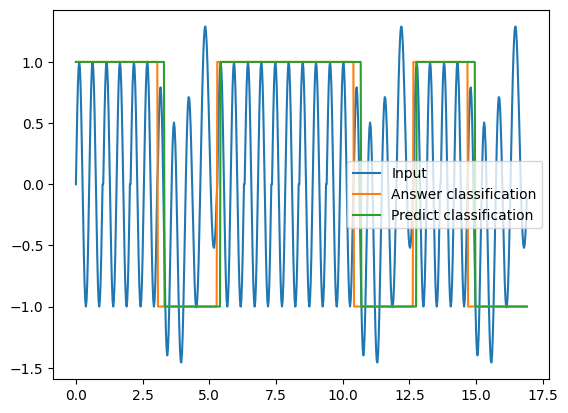

In [19]:
plt.plot(x, p, label='Input')
plt.plot(x, t, label='Answer classification')
plt.plot(x, ans, label='Predict classification')
plt.legend()